In [1]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
import glob
PATH = "/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/detectors/eye/"

all_images = glob.glob("../../dataset/valid/*.JPG")

In [103]:
from datetime import datetime
import pandas as pd

def logger(image, params, path="./"):
    time_str = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    df_headers = pd.DataFrame({
        'log_time': [time_str],
        'image': [image],
        'l_blue': params['l_blue'],
        'l_green': params['l_green'],
        'l_red': params['l_red'],
        'l_has_red_eye': params['l_has_red_eye'],
        'r_blue': params['r_blue'],
        'r_green': params['r_green'],
        'r_red': params['r_red'],
        'r_has_red_eye': params['r_has_red_eye'],
        'l_compliance_score': params['l_compliance_score'],
        'r_compliance_score': params['r_compliance_score'],
    })
    if not os.path.isfile(f'{path}red_eye_logs.csv'):
        df_headers.to_csv(f'{path}red_eye_logs.csv', mode='w', index=False)
    else:
        df_headers.to_csv(f'{path}red_eye_logs.csv', mode='a', index=False, header=False)

## Crop iris region usnig media pipe

In [104]:
def get_face_landmarks(image_path):
    model_path = os.path.join(PATH, "../utilities/face_landmarker.task")
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.FaceLandmarkerOptions(
        base_options=base_options,
        output_face_blendshapes=True,
        output_facial_transformation_matrixes=True,
        num_faces=1,
    )
    detector = vision.FaceLandmarker.create_from_options(options)
    image = mp.Image.create_from_file(image_path)
    detection_result = detector.detect(image)
    face_landmarks_list = detection_result.face_landmarks
    face_landmarks = face_landmarks_list[0]
    return face_landmarks

def crop_iris_region(image_path, landmarks, points, padding=0):
    image = cv2.imread(image_path)
    # image = np.rot90(image)
    height, width = image.shape[:2]
    x_coordinates = [int(landmarks[point].x * width) for point in points]
    y_coordinates = [int(landmarks[point].y * height) for point in points]
    x_min, x_max = min(x_coordinates), max(x_coordinates)
    y_min, y_max = min(y_coordinates), max(y_coordinates)
    cropped_image = image[y_min-padding:y_max+padding, x_min-padding:x_max+padding]
    return cropped_image


## Red eye detection

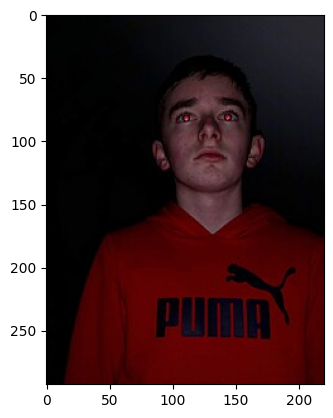

W20231028 16:10:41.792794 292585 face_landmarker_graph.cc:168] Face blendshape model contains CPU only ops. Sets FaceBlendshapesGraph acceleration to Xnnpack.


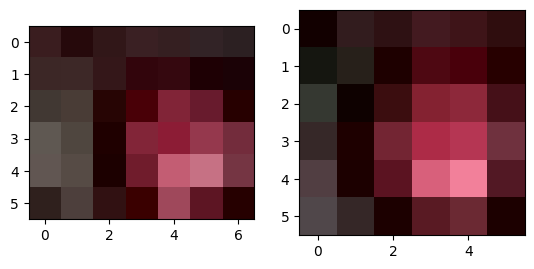

In [105]:
image_path = '/Users/raminduwalgama/Downloads/Red_eye_effect_2.jpg'
# image_path = '/Users/raminduwalgama/Downloads/Archive (1)/001831.jpg'
# image_path = '/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/dataset/invalid/hair_cross.jpeg'
# image_path = '/Users/raminduwalgama/Documents/Projects/OneID/icao-guidelines-server/dataset/valid/N230101778.JPG'
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.show()
face_landmarks = get_face_landmarks(image_path)
LEFT_IRIS = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_LEFT_IRIS for index in pair]))
RIGHT_IRIS = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_RIGHT_IRIS for index in pair]))

left_iris = crop_iris_region(image_path=image_path,
                             landmarks=face_landmarks,
                             points=LEFT_IRIS,
                             padding=0)

right_iris = crop_iris_region(image_path=image_path,
                              landmarks=face_landmarks,
                              points=RIGHT_IRIS,
                              padding=0)

left_iris = cv2.cvtColor(left_iris, cv2.COLOR_BGR2RGB)
right_iris = cv2.cvtColor(right_iris, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.imshow(left_iris)
plt.subplot(1, 2, 2)
plt.imshow(right_iris)
plt.show()


[[False False False False False False False]
 [False False False False False False False]
 [False False False False  True  True False]
 [False False False  True  True False False]
 [False False False  True False False False]
 [False False False False False False False]]

### Red eye detection using compliance score

To assess the presence of red eyes, the approach proposed by Zhang et al. in [41] is used. The iris regions are identified using the pupil positions then, the color of each pixel, belonging to these regions, is compared to an RGB threshold and classified as natural or red eye color. The compliance score is proportional to the percentage of natural pixels in the iris areas.

<i>M. Ferrara, A. Franco, D. Maio and D. Maltoni, "Face Image Conformance to ISO/ICAO Standards in Machine Readable Travel Documents," in IEEE Transactions on Information Forensics and Security, vol. 7, no. 4, pp. 1204-1213, Aug. 2012, doi: 10.1109/TIFS.2012.2198643.</i>

In [106]:
def classify_pixels(iris, threshold=(100, 60, 60)):
    red_channel = iris[:,:,0]
    green_channel = iris[:,:,1]
    blue_channel = iris[:,:,2]

    # Check which pixels are red (based on threshold)
    red_pixels = (red_channel > threshold[0]) & (green_channel < threshold[1]) & (blue_channel < threshold[2])
    natural_pixels = ~red_pixels

    return red_pixels.sum(), natural_pixels.sum()

def compliance_score(iris, threshold=(100, 60, 60)):
    red_count, natural_count = classify_pixels(iris, threshold)
    total_pixels = red_count + natural_count
    if total_pixels == 0:  # avoid division by zero
        return 0

    return (natural_count / total_pixels) * 100

In [109]:
score = compliance_score(left_iris)
print(f"Compliance Score: {score}%")

score = compliance_score(right_iris)
print(f"Compliance Score: {score}%")

0 143
Compliance Score: 100.0%
0 120
Compliance Score: 100.0%


### Red eye detection using average color

In [99]:
# Calculate the average color of the image
average_color_per_row = np.average(right_iris, axis=0)
average_color = np.average(average_color_per_row, axis=0)

# Split the average color into RGB components
red, green, blue = average_color
max_threshold = np.max(average_color[:1])
has_red_eye_ = red > max_threshold

print(red, green, blue, has_red_eye_)

78.52777777777779 29.305555555555554 36.19444444444444 False


In [27]:
print(left_iris.shape)

(6, 7, 3)


In [43]:
def has_red_eye(image):
    # Calculate the average color of the image
    average_color_per_row = np.average(image, axis=0)
    average_color = np.average(average_color_per_row, axis=0)

    # Split the average color into RGB components
    red, green, blue  = average_color
    max_threshold = np.max(average_color[:1])
    has_red_eye_ = red > max_threshold and red > max_threshold

    return red, green, blue, has_red_eye_

## Execute for all images
#### Chosen algorithm: compliance score

In [44]:
LEFT_IRIS = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_LEFT_IRIS for index in pair]))
RIGHT_IRIS = list(set([index for pair in mp.solutions.face_mesh.FACEMESH_RIGHT_IRIS for index in pair]))

In [ ]:
from datetime import datetime

start_time = datetime.now()

for j in range(0, int(len(all_images))):
    image_name = all_images[j]
    face_landmarks = get_face_landmarks(image_path)
    left_iris = crop_iris_region(image_path=image_name,
                             landmarks=face_landmarks,
                             points=LEFT_IRIS,
                             padding=0)

    right_iris = crop_iris_region(image_path=image_name,
                                  landmarks=face_landmarks,
                                  points=RIGHT_IRIS,
                                  padding=0)
    l_red, l_green, l_blue, l_has_red_eye = has_red_eye(left_iris)
    r_red, r_green, r_blue, r_has_red_eye = has_red_eye(right_iris)
    l_compliance_score = compliance_score(left_iris)
    r_compliance_score = compliance_score(right_iris)

    params = {
        'l_red': l_red,
        'l_green': l_green,
        'l_blue': l_blue,
        'l_has_red_eye': l_compliance_score > 95,
        'r_red': r_red,
        'r_green': r_green,
        'r_blue': r_blue,
        'r_has_red_eye': r_compliance_score > 95,
        'l_compliance_score': l_compliance_score,
        'r_compliance_score': r_compliance_score
    }
    logger(image_name, params)

print("------------------COMPLETED------------------")

end_time = datetime.now()
print('Unit: seconds')
print('Duration: {}'.format(end_time - start_time))
print('Duration per image: {}'.format((end_time - start_time)/len(all_images)))

In [108]:
df = pd.read_csv('./red_eye_logs.csv')
df.describe()

,l_blue,l_green,l_red,r_blue,r_green,r_red,l_compliance_score,r_compliance_score
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,500.0
mean,170.170587,119.618210,100.100671,200.608450,143.699800,120.116667,100.0,100.0
std,44.215194,32.684194,29.145871,40.243363,31.017217,28.897136,0.0,0.0
min,12.223776,13.174825,17.839161,20.558333,17.808333,19.766667,100.0,100.0
25%,155.384615,101.615385,82.860140,187.791667,130.629167,103.741667,100.0,100.0
50%,178.758741,124.902098,100.825175,208.291667,149.416667,122.929167,100.0,100.0
75%,199.783217,140.666084,118.762238,224.979167,162.818750,139.527083,100.0,100.0
max,251.251748,223.496503,196.118881,252.883333,229.391667,203.391667,100.0,100.0
